# NDVI Thresholds
*****
# Notebook Summary

* LANDSAT 7 is used to detect changes in plant life both over time and between a baseline period and a target acquisition.
* Very basic xarray manipulations are performed.
* The data is cleaned of clouds and scanlines - both with and without creating mosaics (composite images).

<hr>
# Notebook Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Extents of the Cube](#extents) (the maximum extents)
* [Define the Extents of the Analysis](#define_extents) (extents within the maximum extents)
* [Examine cleaned, time-series data](#time_series)
  * [Retrieve the data from the datacube](#retrieve_data_time_series)
  * [Obtain the clean mask](#obtain_clean_mask_time_series)
  * [Filter out clouds and scan lines](#clean_mask_time_series)
  * [Calculate NDVI](#calculate)
  * [Chose an acquisition date for plotting a map of NDVI](#choose_acq_date)
  * [Examine true and false color maps](#true_false_maps)
  * [Plot NDVI with Thresholds](#plot_maps)
  * [Plot NDVI statistics over time](#time_series_analysis)
* [Examine cleaned, composited data](#mosaic)
  * [Retrieve the data from the datacube](#retrieve_data_mosaic)
  * [Obtain the clean mask](#obtain_clean_mask_mosaic)
  * [Filter out clouds and scan lines, and create a mosaic](#clean_mask_mosaic)
  * [Select a Target Date and Specify a Baseline For Comparison](#baseline)
  * [Calulate the NDVI for the Baseline and Target Scene](#compare)
  * [Plot the NDVI Anomalies](#plot)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [2]:
%matplotlib inline

#Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from dc_notebook_utilities import generate_metadata_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/psycopg2-2.7.5-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## <a id="plat_prod">Choose Platform and Product</a>

In [3]:
# Get available products
products = dc.list_products()
# List LANDSAT 7 products
print(products[["platform", "name"]][products.platform == "LANDSAT_7"])

     platform                      name
id                                     
0   LANDSAT_7  ls7_collections_sr_scene
1   LANDSAT_7          ls7_ledaps_ghana
2   LANDSAT_7   ls7_ledaps_ghana_sample


In [4]:
# These are the platform (satellite) and product (datacube set) 
# used for this demonstration.
platform = "LANDSAT_7"
product = "ls7_ledaps_ghana_sample"

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [5]:
# Get the extents of the cube.
descriptor = api.get_query_metadata(platform=platform, product=product)

# Store the latitudinal and longitudinal extents.
lat, lon = products.resolution[products.platform == platform].any()

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/data_access_api.py:184: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:


In [6]:
from utils.data_cube_utilities.dc_display_map import display_map

#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded, max_lat_rounded = (round(min_lat, 3), round(max_lat, 3))
min_lon_rounded, max_lon_rounded = (round(min_lon, 3), round(max_lon, 3))

#display the total area available in this datacube product that can be used for analysis
display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

In [7]:
# Display metadata.
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

,Min,Max,Resolution
Date:,2015-4-16,2016-4-2,
Longitude:,-1.886,-1.41,0.000269494585236
Latitude:,7.75,9.432,-0.000269494585236


## <a id="define_extents">Define the Extents of the Analysis</a>

In [8]:
# Specify latitude and longitude bounds within the full extents 
# shown in the metadata report above (reduce area for faster processing times).
# Kenya
# min_lon_small, max_lon_small = (35.5, 35.7) # Kenya - Lake Kamnarok (large)
# min_lat_small, max_lat_small = (0.5, 0.7) # Kenya - Lake Kamnarok (large)

# Ghana
min_lat_small, max_lat_small = (8.85, 8.9) # Ghana (small)
min_lon_small, max_lon_small = (-1.75, -1.7) # Ghana (small)

# Display the subset for analysis.
display_map(latitude = (min_lat_small, max_lat_small),longitude = (min_lon_small, max_lon_small))

# <a id="time_series">Examine cleaned, time-series data</a>

## <a id="retrieve_data_time_series">Retrieve the data from the datacube</a>

In [9]:
from datetime import datetime as dt
# Select a date range to retrieve data for.
# start_date      = dt.strptime('2005-01-08', '%Y-%m-%d') # Kenya - Lake Kamnarok (large)
# end_date        = dt.strptime('2005-12-31', '%Y-%m-%d') # Kenya - Lake Kamnarok (large)
start_date      = dt.strptime('2015-04-16', '%Y-%m-%d') # Ghana (small)
end_date        = dt.strptime('2016-04-02', '%Y-%m-%d') # Ghana (small)

time_extents = (start_date, end_date)
landsat_dataset = dc.load(lat = (min_lat_small, max_lat_small),
                          lon = (min_lon_small, max_lon_small),
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']) 

## <a id="obtain_clean_mask_time_series">Obtain the clean mask</a>

In [10]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(landsat_dataset, platform)

## <a id="clean_mask_time_series">Filter out clouds and scan lines</a>

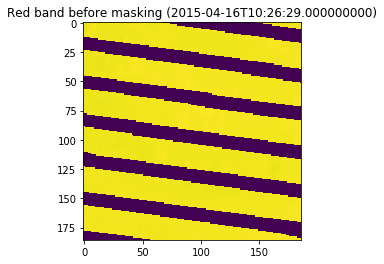

In [11]:
plt.imshow(landsat_dataset.isel(time=0).red)
plt.title("Red band before masking ({})".format(str(landsat_dataset.time.values[0])))
plt.show()

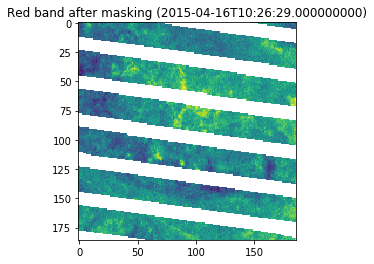

In [12]:
cleaned_landsat_dataset = landsat_dataset.where(clean_mask)
plt.imshow(cleaned_landsat_dataset.isel(time=0).red)
plt.title("Red band after masking ({})".format(str(landsat_dataset.time.values[0])))
plt.show()

## <a id='calculate'>Calculate NDVI</a>

In [13]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
ndvi_data_arr = NDVI(cleaned_landsat_dataset)
ndvi = ndvi_data_arr.to_dataset(name='ndvi')

## <a id='choose_acq_date'>Chose an acquisition date for plotting a map of NDVI</a>

In [14]:
acquisition_dates = np.array([pd.to_datetime(str(time)).strftime('%Y-%m-%d') for time in cleaned_landsat_dataset.time.values])
print("Acquisition Dates:")
print(acquisition_dates)

Acquisition Dates:
['2015-04-16' '2015-08-06' '2015-10-25' '2015-11-10' '2015-11-26'
 '2015-12-12' '2015-12-28' '2016-01-13' '2016-01-29' '2016-02-14'
 '2016-03-17']


In [28]:
# acquisition_date = '2005-01-08' # Kenya - Lake Kamnarok (large)
acquisition_date = '2015-08-06' # Ghana (small)
acquisition_index = np.argmax(acquisition_dates == acquisition_date)
if acquisition_index == 0 and acquisition_date != acquisition_dates[0]:
    raise ValueError("Acquisition date '{}' is not in the list of acquisition dates above.".format(acquisition_date))

## <a id='true_false_maps'>Examine true and false color maps</a>

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


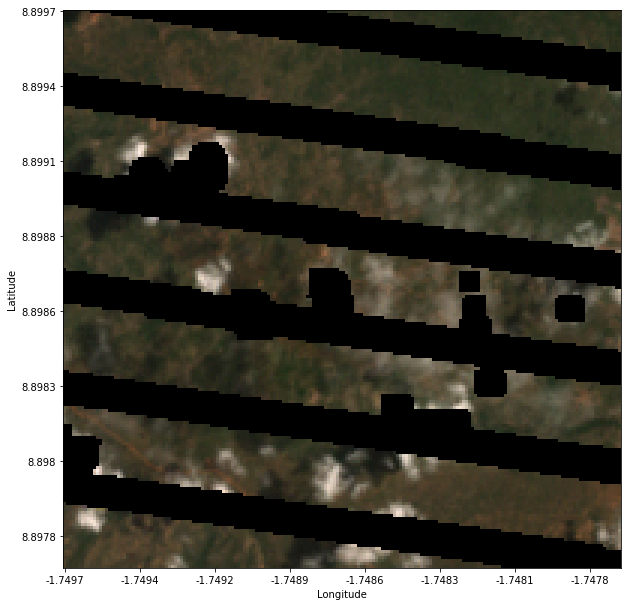

In [30]:
#True color plot
from utils.data_cube_utilities.dc_rgb import rgb
rgb(cleaned_landsat_dataset, at_index=acquisition_index, bands=['red', 'green', 'blue'])

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


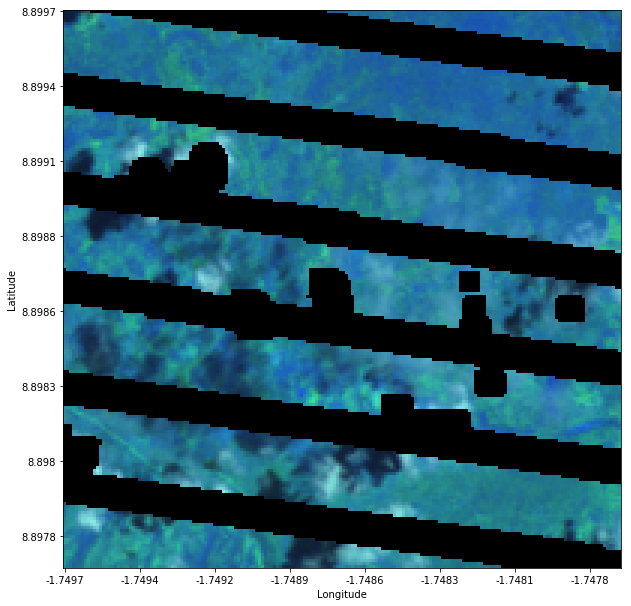

In [31]:
#False color plot
rgb(cleaned_landsat_dataset, at_index=acquisition_index, bands=['green', 'swir1', 'nir'])

## <a id="plot_maps">Plot NDVI with Thresholds</a>

In [32]:
from utils.data_cube_utilities.dc_display_map import display_map
ndvi_plotting_data = ndvi.isel(time=acquisition_index)

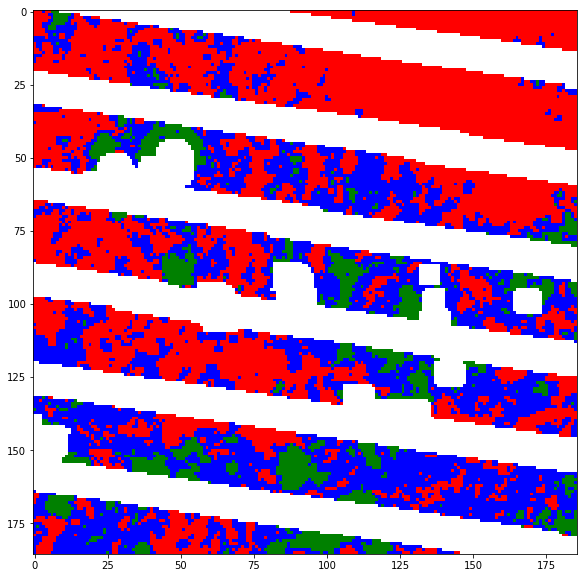

In [33]:
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map
th = [-0.2, 0.2] # Color thresholds
cmap = create_discrete_color_map(th=th, colors=['green', 'blue', 'red'], data_range=[-1,1])
plt.figure(figsize=(10,10))
plt.imshow(ndvi_plotting_data.ndvi.values, cmap=cmap)

## <a id="time_series_analysis">Plot NDVI statistics over time</a>

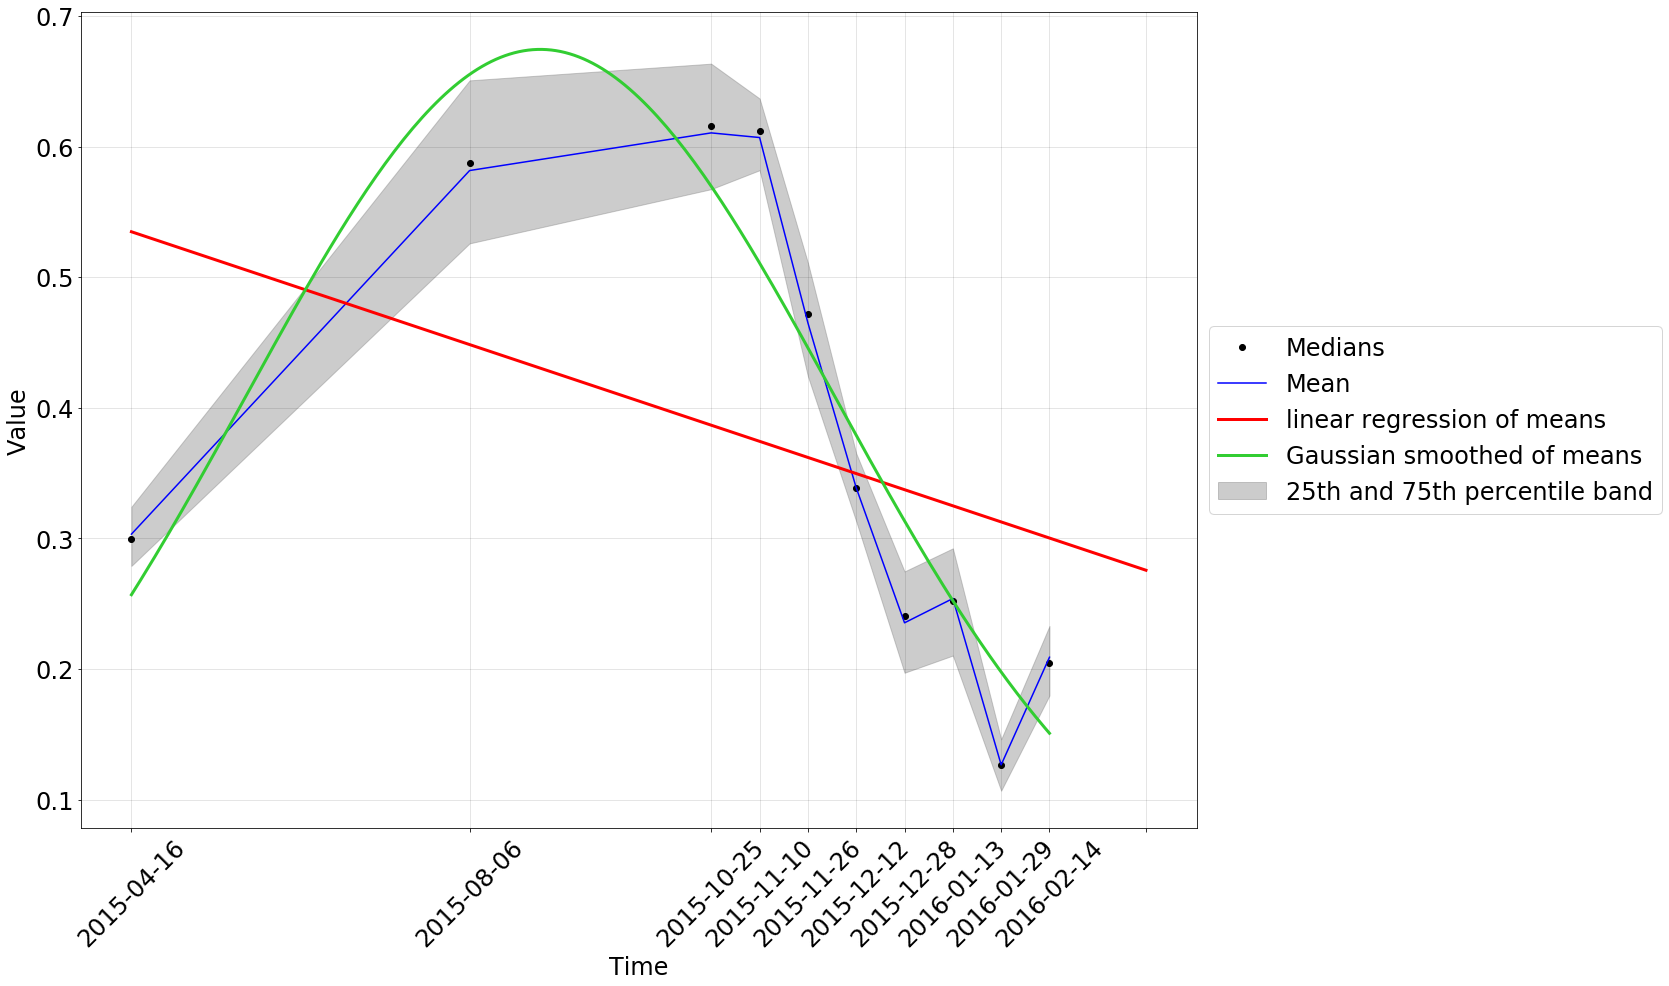

In [34]:
from utils.data_cube_utilities.plotter_utils import plot_band
plot_band(ndvi_data_arr)

# <a id="mosaic">Examine cleaned, composited data</a>

## <a id="retrieve_data_mosaic">Retrieve the data from the datacube</a>

In [35]:
start_date   = min_date
end_date     = max_date
time_extents = (start_date, end_date)
landsat_dataset = dc.load(lat = (min_lat_small, max_lat_small),
                          lon = (min_lon_small, max_lon_small),
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'nir', 'pixel_qa']) 

## <a id="obtain_clean_mask_mosaic">Obtain the clean mask</a>

In [36]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
#Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(landsat_dataset, platform)

## <a id="clean_mask_mosaic">Filter out clouds and scan lines, and create a mosaic</a>

In [37]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic 
cleaned_landsat_dataset_mosaic = \
    create_mosaic(landsat_dataset, reverse_time=False, clean_mask=clean_mask)

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/dc_utilities.py:203: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for band in dataset:


## <a id="baseline">Select a Target Date and Specify a Baseline For Comparison</a>

In [38]:
#get a list of available image aquisition dates
acquisitions_list = np.array(api.list_acquisition_dates(product, longitude=(min_lon, max_lon), latitude=(min_lat, max_lat), time = time_extents))
print("There are {} acquisitions to choose from:".format(len(acquisitions_list)))
for index, acquisition in enumerate(acquisitions_list):
    print(index, acquisition)

There are 11 acquisitions to choose from:
0 2015-04-16 10:26:29
1 2015-08-06 10:27:04
2 2015-10-25 10:27:38
3 2015-11-10 10:27:53
4 2015-11-26 10:28:07
5 2015-12-12 10:28:23
6 2015-12-28 10:28:35
7 2016-01-13 10:28:52
8 2016-01-29 10:29:02
9 2016-02-14 10:29:08
10 2016-03-17 10:29:22


/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/data_access_api.py:225: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:


In [39]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic, create_median_mosaic, \
                                                create_max_ndvi_mosaic, create_min_ndvi_mosaic

# Select a scene to check for anomalies (one of the acquisition dates shown above).
# acquisition_index = 146 # Check for anomalies in the middle of 2015. (Kenya - Lake Kamnarok)
acquisition_index = 7 # Check for anomalies at the beginning of 2016. (Ghana (small))

scene_sel_datetime = acquisitions_list[acquisition_index]
print("Date selected to check for anomalies: ", scene_sel_datetime)

# Select scenes to form a baseline.
# baseline_date_indices = list(range(0,78)) # Use 2005-2012 as the baseline (Kenya - Lake Kamnarok)
baseline_date_indices = list(range(0,7)) # Use 2015 as the baseline (Ghana (small))

baseline_datetimes = acquisitions_list[baseline_date_indices]
print("First and last dates selected for baseline: ", baseline_datetimes[[0,-1]])

#Create a dictionary of the different mosaic method options
mosaic_methods = {'Most Recent':create_mosaic, 'Least Recent':create_mosaic,'Median':create_median_mosaic,
                  'Max NDVI':create_max_ndvi_mosaic, 'Min NDVI':create_min_ndvi_mosaic}

# Select a mosaic method for the baseline 
# (One of ['Most Recent','Least Recent','Median','Max NDVI','Min NDVI']).
mosaic_method_label = 'Max NDVI'

mosaic_method = mosaic_methods[mosaic_method_label]
print("Selected mosaic method: ", mosaic_method_label)

# Select a percentage threshold for anomalies.
threshold_percent = 0.60
print("Threshold percentage selected for anomalies: {}%".format(threshold_percent*100))

Date selected to check for anomalies:  2016-01-13 10:28:52
First and last dates selected for baseline:  [datetime.datetime(2015, 4, 16, 10, 26, 29)
 datetime.datetime(2015, 12, 28, 10, 28, 35)]
Selected mosaic method:  Max NDVI
Threshold percentage selected for anomalies: 60.0%


In [40]:
import datetime
#Initialize baseline mosaic for comparison
baseline_mosaic = None

# We need to reverse the direction of the compositing over time if "Most Recent" selected
reverse_time = True if mosaic_method_label == 'Most Recent' else False
for index in range(len(baseline_datetimes)):
    data = api.get_dataset_by_extent(product, latitude=(min_lat_small, max_lat_small), longitude=(min_lon_small, max_lon_small), 
                                    time=(baseline_datetimes[index],(baseline_datetimes[index+1] if index != len(baseline_datetimes)-1 else baseline_datetimes[index]+datetime.timedelta(seconds=1))),
                                    measurements=['red', 'nir', 'pixel_qa'])
    clean_mask = landsat_qa_clean_mask(data, platform)
    baseline_mosaic = mosaic_method(data, intermediate_product=baseline_mosaic, reverse_time=reverse_time, clean_mask=clean_mask)

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/dc_utilities.py:203: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for band in dataset:


## <a id="compare">Calulate the NDVI for the Baseline and Target Scene</a>

In [41]:
import sys #required for epsilon (in case the baseline is zero)

#Calculate the NDVI baseline values
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
ndvi_baseline = NDVI(baseline_mosaic)

#Calculate the NDVI values in the target scene
ndvi_scene = NDVI(cleaned_landsat_dataset_mosaic)

#Determine the percentage change
percentage_change = abs((ndvi_baseline - ndvi_scene) / (ndvi_baseline+sys.float_info.epsilon))

## <a id="plot">Plot the NDVI Anomalies</a>

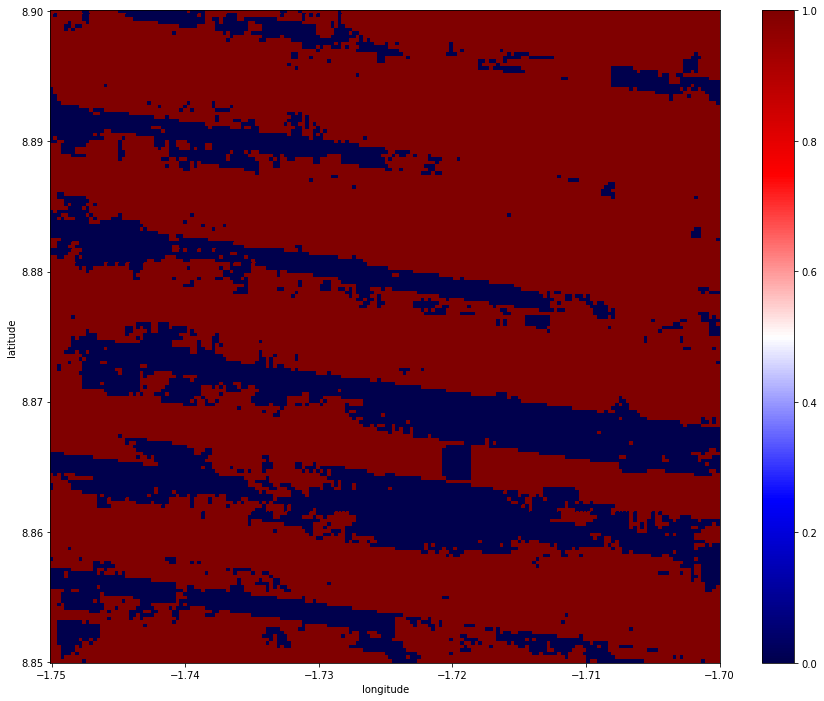

In [42]:
import matplotlib.pyplot as plt

# Use a cutoff value
anom = percentage_change > threshold_percent

# Set plot size
plt.figure(figsize = (15,12))

anom.plot(cmap='seismic')

If you used the original values for everything up to this point, you can clearly see an NDVI anomaly. This indicates that there was a measurable difference in the amount of photosynthetic plants in the area compared to the standard defined by the baseline composite image.

In [43]:
# Examine the area again
display_map(latitude = (.5, .7),longitude = (35.5, 35.7))

The anomaly we detected was Lake Kamnarok in Kenya. Lake Kamnarok, named after all the <i>Narok</i> plants in it, dried up in 2015. When it did, a significant number of the plants inside and around it died.  Without any prior knowledge about the lake, we were able to determine that there was a significant change in the plant life there using satellite imagery.